In [172]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as clrs
from mpl_toolkits.mplot3d import Axes3D

def scatter3d(x, y, z, cs, title, xlabel, ylabel, zlabel, cslabel):
    cm = plt.get_cmap('jet')
    cNorm = clrs.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize=(15, 10))
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_label(cslabel)
    plt.show()

In [208]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelBinarizer, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder

In [174]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [175]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        average_allowed_charges = X[:, 1] / X[:, 0]
        average_payment = X[:, 2] / X[:, 0]
        return np.c_[X, average_allowed_charges, average_payment]

In [176]:
class LogAndPowerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        allowed_services = np.log1p(X[:, 0])
        allowed_charges = np.power(X[:, 1], 0.1)
        payment = np.power(X[:, 2], 0.1)
        average_allowed_charges = np.power(X[:, 3], 0.3)
        average_payment = np.power(X[:, 4], 0.3)
        return np.c_[allowed_services, allowed_charges, payment, average_allowed_charges, average_payment]

In [195]:
class ModelApplier(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y=None):
        self.model.fit(X, y)
        return self
    
    def transform(self, X, y=None):
        pred_values = self.model.labels_
        return np.c_[X, pred_values]

In [188]:
class Debugger(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print(X)
        return X

In [178]:
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [179]:
xls = pd.ExcelFile('data/Y2015_33010.xlsx')
df = xls.parse('Y2015_33010', skiprows=4, index_col=None, na_values=['NaN'])
df = df.loc[:, ~df.columns.str.contains('Unnamed')]
df = df[df['MODIFIER'] == 'TOTAL']

In [180]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(['ALLOWED SERVICES', 'ALLOWED CHARGES', 'PAYMENT'])),
    ('imputer', SimpleImputer(strategy='median')),
    ('attrs_adder', CombinedAttributesAdder()),
    ('log_transform', LogAndPowerTransformer()),
    ('std_scaler', StandardScaler())
])

In [181]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(['DESCRIPTION'])),
    ('label_binarizer', MyLabelBinarizer())
])

In [182]:
num_cat_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [183]:
pre_pipeline = Pipeline([
    ('num_cat_pipeline', num_cat_pipeline),
    ('pca', PCA())
])

In [214]:
contamination = 0.025

pipeline = Pipeline([
    ('preprocessing', pre_pipeline),
    ('knn', ModelApplier(KNN(contamination=contamination)))
])

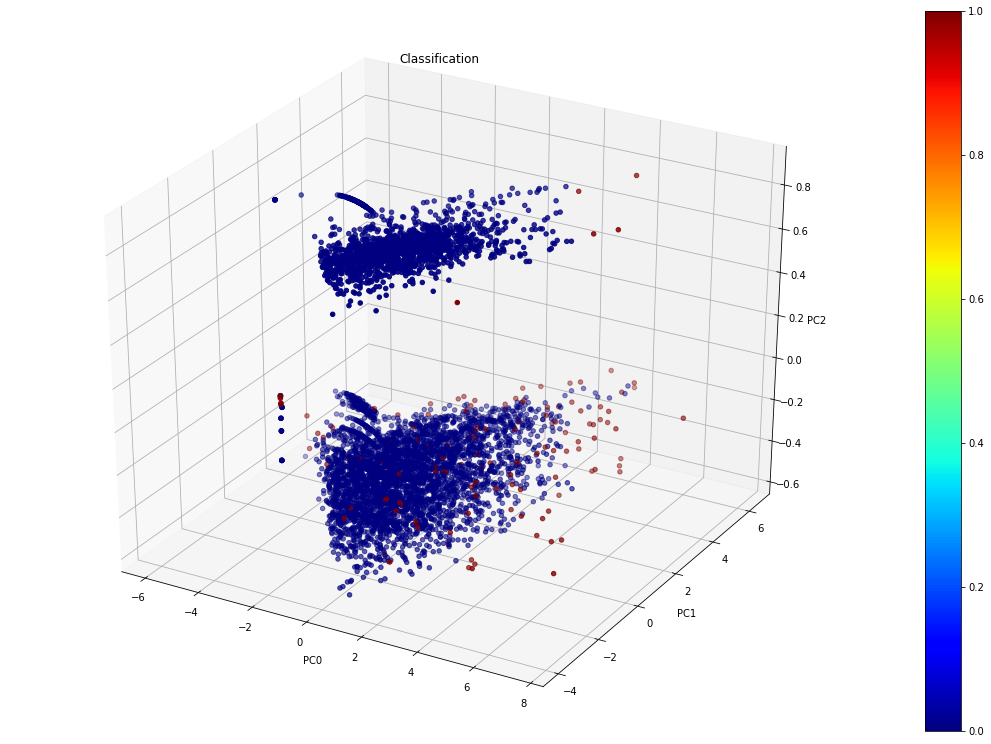

In [215]:
_df = pd.DataFrame(pipeline.fit_transform(df))
scatter3d(_df[0], _df[1], _df[2], _df[len(_df.columns) - 1], 'Classification', 'PC0', 'PC1', 'PC2', 'Fraud')